In [40]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import torchvision.transforms.functional as TF

import seaborn as sns

In [41]:
# Define the path to the dataset
data_dir = "affectnet"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

In [42]:
# Define image transformations with data augmentation
transform_train = transforms.Compose([
    transforms.Resize((48, 48)),  # Resize images to 48x48
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(10),  # Randomly rotate images up to 10 degrees
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images
])

transform_test = transforms.Compose([
    transforms.Resize((48, 48)),  # Resize images to 48x48
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images
])


In [43]:


# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data = []  # List to store (image, label) pairs
        self.transform = transform
        
        for category in os.listdir(data_folder):
            label = int(category[-3:]) - 1
            category_folder = os.path.join(data_folder, category)
            for image_file in os.listdir(category_folder):
                image_path = os.path.join(category_folder, image_file)
                self.data.append((image_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

# Define transformations for training and testing
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(48, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [44]:
# Create train and test datasets with data augmentation
train_dataset = CustomDataset(train_dir, transform=transform_train)
test_dataset = CustomDataset(test_dir, transform=transform_test)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [45]:
# Define the emotion categories
emotion_categories = {
    1: "Neutral",
    2: "Happiness",
    3: "Sadness",
    4: "Surprise",
    5: "Afraid",
    6: "Disgusted",
    7: "Angry",
    8: "Contempt"
}


In [46]:
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(EmotionCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 6 * 6, 512),  # Adjusted input size (128 * 6 * 6)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


In [47]:

# Initialize the model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionCNN(num_classes=8).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [48]:
# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Training loop
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()  # Update learning rate
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {running_loss/len(train_loader)}")


Epoch [1/20] Loss: 1.9773861954086704
Epoch [2/20] Loss: 1.7941233995955
Epoch [3/20] Loss: 1.712224788270016
Epoch [4/20] Loss: 1.656743162315384
Epoch [5/20] Loss: 1.6216146929061364
Epoch [6/20] Loss: 1.5590821120903078
Epoch [7/20] Loss: 1.5389576112693137
Epoch [8/20] Loss: 1.5231946695007776
Epoch [9/20] Loss: 1.5217750248638724
Epoch [10/20] Loss: 1.5137977626943877
Epoch [11/20] Loss: 1.5051442046879757
Epoch [12/20] Loss: 1.5052111310514844
Epoch [13/20] Loss: 1.5131396834666913
Epoch [14/20] Loss: 1.4985822400583428
Epoch [15/20] Loss: 1.496793796900313
Epoch [16/20] Loss: 1.4940828763039007
Epoch [17/20] Loss: 1.5011635767786127
Epoch [18/20] Loss: 1.50475965965132
Epoch [19/20] Loss: 1.496623042382692
Epoch [20/20] Loss: 1.501043605177026


In [49]:
# Evaluation on the test set
model.eval()
correct = 0
total = 0
all_predicted = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Accuracy on test set: {100 * correct / total:.2f}%")


Accuracy on test set: 42.77%


In [50]:
# Create a confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predicted)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[181  14  71  47  32  18  61  76]
 [  6 343  25  20   8  19  13  66]
 [ 79  27 184  27  42  45  61  35]
 [ 55  40  42 206  92  23  23  19]
 [ 38  19  43  97 225  29  44   5]
 [ 42  32  74  27  26 171  96  32]
 [ 51  10  59  21  29  91 205  34]
 [ 64  99  35  14  15  39  38 196]]


<AxesSubplot: >

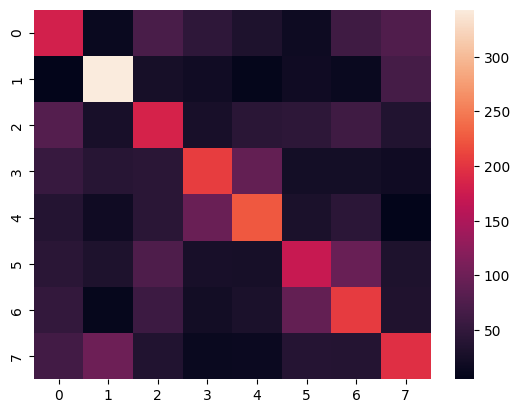

In [51]:
sns.heatmap(conf_matrix)

In [52]:
# Save the model to an h5 file
torch.save(model.state_dict(), "model4.h5")

In [53]:
# Function to decode emotion labels
def decode_emotion_label(label):
    return emotion_categories[label]

# Example usage of decoding labels
example_label = 1
print(f"Emotion Category for label {example_label}: {decode_emotion_label(example_label)}")

Emotion Category for label 1: Neutral


In [54]:
# Function to create a radar chart for emotion categories and probabilities
def radar_chart_for_image(model, image):
    model.eval()
    image = image.to(device)
    with torch.no_grad():
        output = model(image.unsqueeze(0))
        probabilities = torch.softmax(output, dim=1).squeeze().cpu().numpy()

    angles = np.linspace(0, 2 * np.pi, len(emotion_categories), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))
    probabilities = np.concatenate((probabilities, [probabilities[0]]))

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, probabilities, 'o-', linewidth=2)
    ax.fill(angles, probabilities, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(list(emotion_categories.values()))
    ax.set_title("Emotion Probabilities", fontsize=14)
    ax.grid(True)


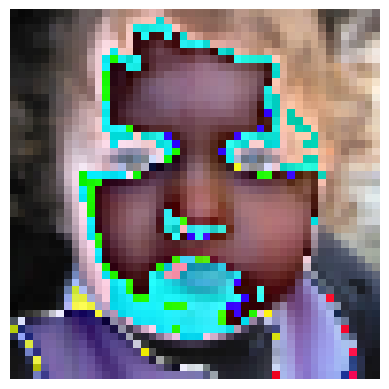

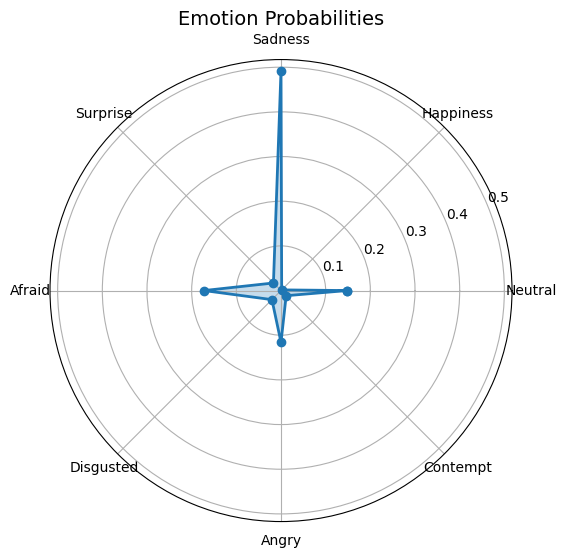

In [55]:
from PIL import Image

# Load the first image from the test set
sample_image, sample_label = test_dataset[0]

# Display the image
# Convert the image tensor to a PIL image
sample_image_pil = transforms.ToPILImage()(sample_image)

# Display the image
plt.imshow(sample_image_pil)
plt.axis('off')
plt.show()

# Create the radar chart for the image's emotion probabilities
radar_chart_for_image(model, sample_image)
plt.show()